In [185]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../../figures/')

In [186]:
cdict = {
    'True (gained)': 'tab:green',
    'True': 'green',
    'False': 'tab:blue',
    'False (lost)': 'tab:red',
    'control': 'black',
    'False (any)': 'tab:orange'
}

# TODOs

Important
- put the VZRD table on the website and link it
- zip website plots and put it on an extra zenodo or on github (maybe better if not too big?)

# Define Functions

In [137]:
def plot_KM(sdf, dataset, x, show=True, ax=None, **plot_kwargs):
    # This is basically a Kaplan Meier plot
    N = len(sdf.perturbation.unique())  # number of perturbations
    with sns.axes_style('whitegrid'):
        ax = pl.subplots(figsize=(8,6), dpi=80)[-1] if ax is None else ax
    total_sig = len(sdf[(sdf.n==np.max(sdf.n)) & (sdf.significant_adj=='True')])  # number of sig perts without subsampling (i.e. in original dataset)
    # record highest number of cells when significance was initially lost by a perturbation group
    timedf = sdf[sdf['significant_adj_new'] == 'False (lost)'].groupby('perturbation').max(x)
    X = [np.max(sdf[x])] + list(timedf[x].sort_values(ascending=False))
    Y = [total_sig] + list(np.arange(len(X)-1)[::-1] - len(timedf) + total_sig)  # running sum
    Y = np.array(Y) / N  # normalize to fraction of perts significant
    # ax.scatter(X[1:], np.array(Y[1:] + 1/N), marker='+', s=50, linewidths=3)
    # make piecewise constant, fixed at upper value
    # essentially this is a Kaplan Meier plot that goes from right to left.
    X_ = []
    Y_ = []
    for i in range(len(X)-1):
        X_.extend([X[i], X[i+1]])
        Y_.extend([Y[i], Y[i]])
    ax.plot(X_, Y_, label=dataset.replace('TAP_SCREEN__chromosome_', 'chr'), linewidth=3, **plot_kwargs)
    import matplotlib.ticker as mtick
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
    ax.set_xlabel('Number of cells' if x=='ncells' else 'Average number of counts per cell')
    ax.set_ylabel('Fraction of Perturbations\nwith sign. E-test')
    ax.set_title(f'Loss of significance with decreasing {x}\nin {dataset}')
    if show: 
        pl.show()
    else:
        return ax

def plot_strip(sdf, dataset, xkey='ncells', X='n', save=False, show=True, ax=None):
    # prep data
    sdf = sdf[sdf.ncells>2].copy() if xkey=='ncells' else sdf  # not enough cells for e-test!
    sdf['significant_adj_new'][sdf.significant_adj_new=='True (gained)'] = 'True'  # we don't care about gains (unlike body builders)
    sdf = sdf[sdf.perturbation != control]
    
    # strip plot
    with sns.axes_style('whitegrid'):
            ax = pl.subplots(figsize=(8,6), dpi=80)[-1] if ax is None else ax
    ax.set_yscale('log')
    sns.stripplot(data=sdf, x=X, y='edist', hue='significant_adj_new', palette=cdict, ax=ax)
    
    # median line(s)
    sdf['significant_adj_new'][(sdf.significant_adj_new=='False (lost)') | (sdf.significant_adj_new=='False')] = 'False (any)'  # too few points otherwise for median line
    med_df = sdf.groupby(['significant_adj_new', X]).median()
    for idx in med_df.index.get_level_values(0).unique():
        ax.plot(np.arange(len(med_df.loc[idx])), med_df.loc[idx].edist, label=f'median {idx}', linewidth=5, color=cdict[idx])
    
    # plot auxilaries
    ax.set_ylabel(f'E-distance to unperturbed')
    ax.set_xlabel(xkey)
    ax.set_title(dataset)
    ax.legend(title='E-test significant\n(p-value < 0.05)')
    if xkey=='ncells':
        ax.set_xticklabels(np.round(sdf[xkey].unique(), 3))
    else:
        pass#ax.set_xticklabels(np.array(sdf.groupby(X).mean()[xkey], dtype=int))
    if save: pl.savefig(f'../{dataset}_{xkey}_stripplot.pdf', bbox_inches='tight')
    if show: pl.show()
        
def plot_freqs(sdf, ax, xkey='ncells', X='n'):
    sdf = sdf[sdf.ncells>2].copy() if xkey=='ncells' else sdf  # not enough cells for e-test!
    sdf['significant_adj_new'][sdf.significant_adj_new=='True (gained)'] = 'True'  # we don't care about gains (unlike body builders)
    sdf = sdf[sdf.perturbation != control]

    cdf = sdf.groupby(X).significant_adj_new.value_counts(sort=False, normalize=True)
    cdf.name = 'frequency'
    cdf = cdf.reset_index()

    c = cdf[X].unique()
    pos_dict = dict(zip(c, np.arange(len(c))))
    y_bot = np.zeros(len(c))
    for cat in cdf.significant_adj_new.unique():
        y = cdf[cdf.significant_adj_new==cat].frequency
        pos_idx = cdf[cdf.significant_adj_new==cat][X]
        x = [pos_dict[i] for i in pos_idx]
        ax.bar(x, y, bottom=y_bot[x], color=cdict[cat], width=0.6)
        y_bot[x] += y
    #ax.set_xticks(np.arange(len(c)))
    #ax.set_xticklabels(np.round(sdf[xkey].unique(), 3))
    ax.grid(False)
    ax.set_ylabel('% perturbations')
    import matplotlib.ticker as mtick
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
    ax.set_xlabel(f'Number of {xkey[1:]} per perturbation after subsampling')
    if xkey=='ncells':
        ax.set_xticklabels(np.round(sdf[xkey].unique(), 3))
    else:
        pass#ax.set_xticklabels(np.array(sdf.groupby(X).mean()[xkey], dtype=int))

def plot_scatter(sdf, dataset, x, save=True, show=True, ax=None):
    # Continuous scale + KM plot
    with sns.axes_style('whitegrid'):
        ax = pl.subplots(figsize=(8,6), dpi=80)[-1] if ax is None else ax
    ax.set_yscale('log')
    #ax.set_xscale('log')
    sns.scatterplot(data=sdf, x=x, y='edist', hue='significant_adj_new', palette=cdict, ax=ax)
    ax.set_ylabel(f'E-distance to {control}')
    ax.set_xlabel(x)
    ax.set_title(f'Loss of E-test significances with decreasing {x}\nin {dataset}')
    #ax.plot(med_df.index, med_df.edist, label='median line', linewidth=6, color='black')
    ax.legend(title='E-test significant\n(p-value < 0.05)')
    if save: pl.savefig(f'../{dataset}_{x}.pdf', bbox_inches='tight')
    if show: pl.show()

# Ncounts

In [170]:
files = list(Path(f'../snakemake/tables/').glob('effect_of_ncounts_*'))
# exclude files with few total perturbations or no significant ones to lose to begin with
selected_files = []
for file in files:
    sdf = pd.read_csv(file, index_col=0)
    if len(sdf.perturbation.unique())<30 or ('True' not in sdf.significant_adj_new.value_counts().index) or ('False' not in sdf.significant_adj_new.value_counts().index):
        continue
    else:
        selected_files.append(file)

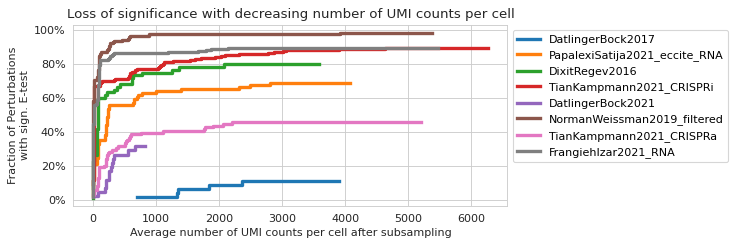

In [138]:
with sns.axes_style('whitegrid'):
    ax = pl.subplots(figsize=(7,3), dpi=80)[-1]
for file in selected_files:
    dataset = file.name.replace('effect_of_ncounts_', '').replace('_tables.csv', '')
    sdf = pd.read_csv(file, index_col=0)
    ax = plot_KM(sdf, dataset, 'ncounts', show=False, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f'Loss of significance with decreasing number of UMI counts per cell')
ax.set_xlabel('Number of UMI counts per cell after subsampling')
# ax.set_xscale('log')
pl.savefig(figure_path / f'Fig5_ncounts_joint_KMplot.pdf', bbox_inches='tight')
pl.show()

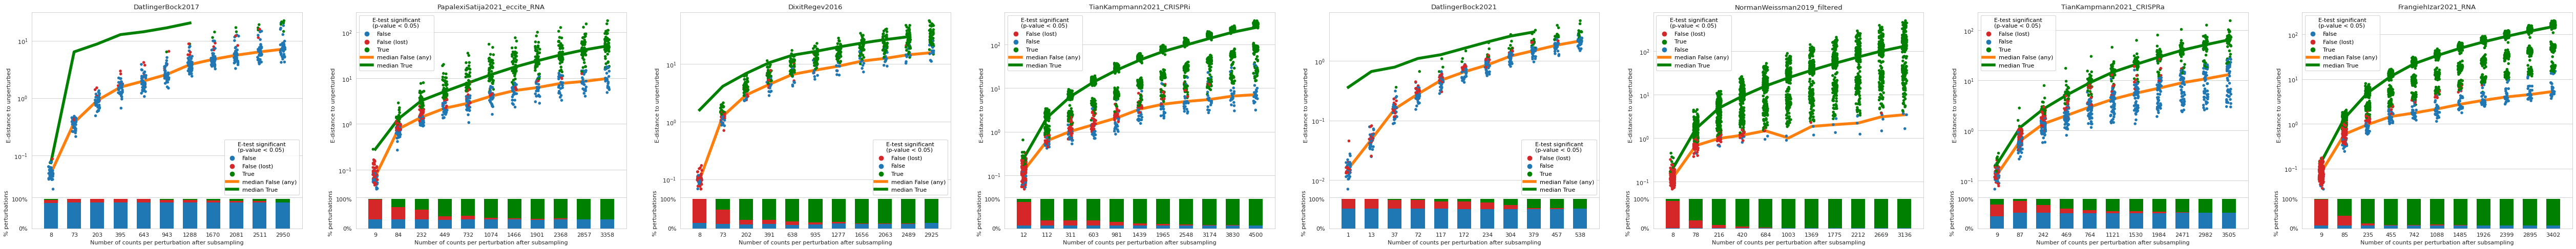

In [139]:
N=len(selected_files)
with sns.axes_style('whitegrid'):
    axss = pl.subplots(2, N, figsize=(10*N, 7), dpi=80, gridspec_kw={'height_ratios':[6, 1], 'hspace': 0}, sharex='col')[-1]
for file, axs in zip(selected_files, axss.T):
    sdf = pd.read_csv(file, index_col=0)
    dataset = file.name.replace('effect_of_ncounts_', '').replace('_tables.csv', '')
    plot_strip(sdf, dataset, 'ncounts', ax=axs[0], save=False, show=False)
    plot_freqs(sdf, ax=axs[1], xkey='ncounts')
    axs[0].set_xticklabels(np.array(sdf.groupby('n').mean()['ncounts'], dtype=int))
    axs[0].set_xlabel('Average number of UMI counts per cell after subsampling')
pl.savefig(figure_path / f'Fig5_ncounts_joint_all_strips.pdf', bbox_inches='tight')
pl.show()    

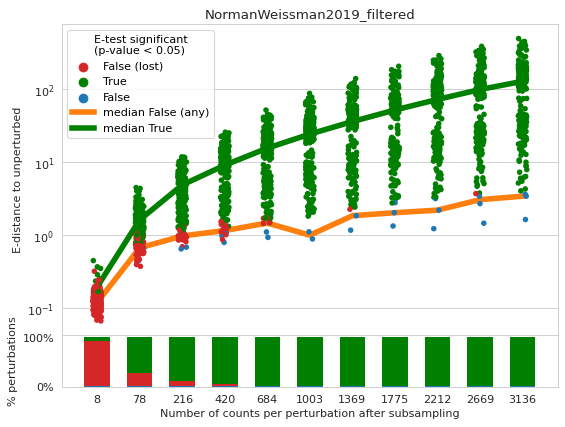

In [171]:
# Ncells Norman
file = Path('../snakemake/tables/effect_of_ncounts_NormanWeissman2019_filtered_tables.csv')
with sns.axes_style('whitegrid'):
    axs = pl.subplots(2, 1, figsize=(8*1, 6), dpi=80, gridspec_kw={'height_ratios':[6, 1], 'hspace': 0}, sharex='col')[-1]
sdf = pd.read_csv(file, index_col=0)
dataset = file.name.replace('effect_of_ncounts_', '').replace('_tables.csv', '')
plot_strip(sdf, dataset, 'ncounts', ax=axs[0], save=False, show=False)
plot_freqs(sdf, ax=axs[1], xkey='ncounts')
axs[0].set_xticklabels(np.array(sdf.groupby('n').mean()['ncounts'], dtype=int))
axs[0].set_xlabel('Average number of UMI counts per cell after subsampling')
pl.savefig(figure_path / f'Fig5_ncounts_joint_Norman_strips.pdf', bbox_inches='tight')
pl.show()    

# Ncells (N_min=1000) [old]

In [481]:
files = list(Path(f'../snakemake/tables/').glob('2_effect_of_ncells_*'))
# exclude files with few total perturbations or no significant ones to lose to begin with
selected_files = []
for file in files:
    sdf = pd.read_csv(file, index_col=0)
    if len(sdf.perturbation.unique())<10 or ('True' not in sdf.significant_adj_new.value_counts().index):
        continue
    else:
        selected_files.append(file)

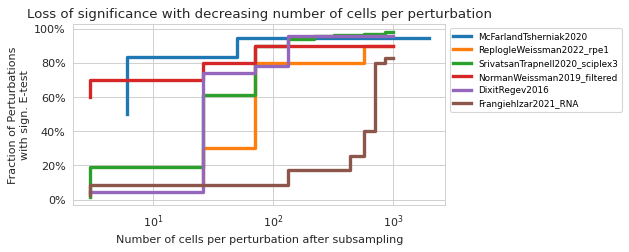

In [482]:
with sns.axes_style('whitegrid'):
    ax = pl.subplots(figsize=(6,3), dpi=80)[-1]
for i, file in enumerate(selected_files):
    dataset = file.name.replace('2_effect_of_ncells_', '').replace('_tables.csv', '')
    sdf = pd.read_csv(file, index_col=0)
    sdf = sdf[sdf.ncells>2].copy()  # not enough cells for e-test!
    ax = plot_KM(sdf, dataset, 'ncells', show=False, ax=ax)
ax.legend(fontsize=8, bbox_to_anchor=(1,1))
ax.set_title(f'Loss of significance with decreasing number of cells per perturbation')
ax.set_xlabel('Number of cells per perturbation after subsampling')
ax.set_xscale('log')
# pl.savefig(f'../ncells_joint_KMplot.pdf', bbox_inches='tight')
pl.show()

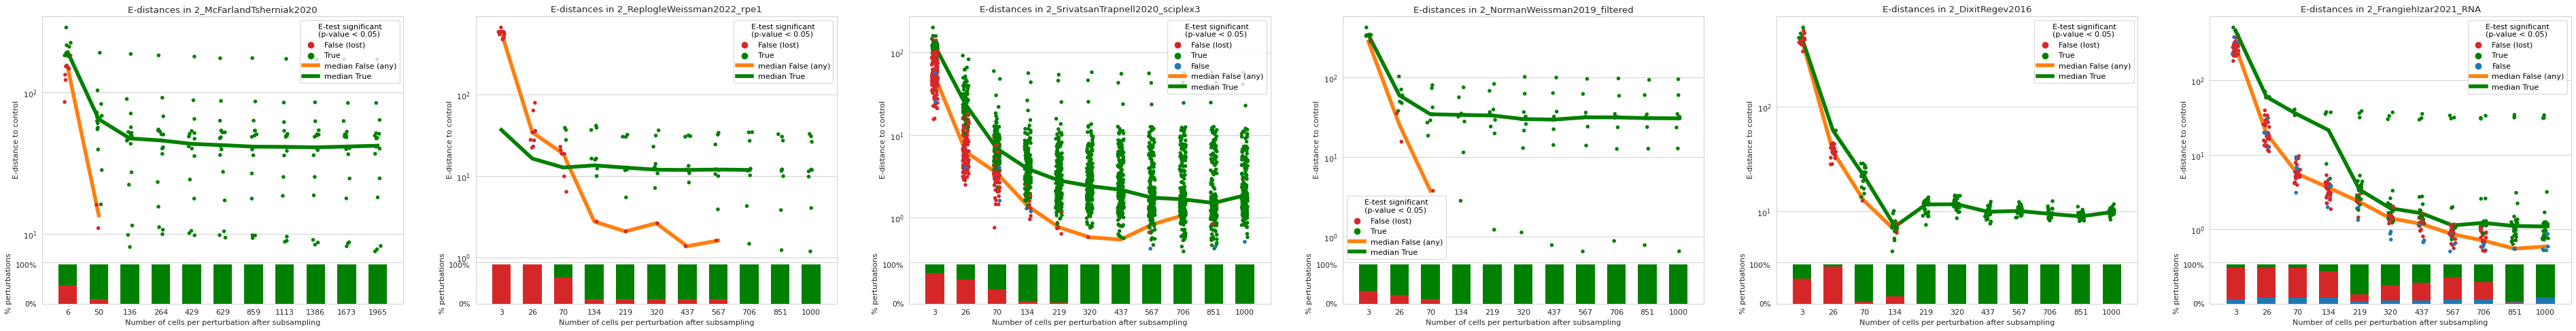

In [483]:
# Ncells
files = selected_files
N=len(files)
with sns.axes_style('whitegrid'):
    axss = pl.subplots(2, N, figsize=(10*N, 7), dpi=80, gridspec_kw={'height_ratios':[6, 1], 'hspace': 0}, sharex='col')[-1]
for file, axs in zip(files, axss.T):
    sdf = pd.read_csv(file, index_col=0)
    dataset = file.name.replace('effect_of_ncells_', '').replace('_tables.csv', '')
    plot_strip(sdf, dataset, 'ncells', ax=axs[0], save=False, show=False)
    plot_freqs(sdf, ax=axs[1], xkey='ncells')
pl.show()    

# Ncells (N_min=500)

In [163]:
files = list(Path(f'../snakemake/tables/').glob('500_effect_of_ncells_*'))
# exclude files with few total perturbations or no significant ones to lose to begin with
selected_files = []
for file in files:
    sdf = pd.read_csv(file, index_col=0)
    if len(sdf.perturbation.unique())<10 or ('True' not in sdf.significant_adj_new.value_counts().index):
        continue
    else:
        selected_files.append(file)

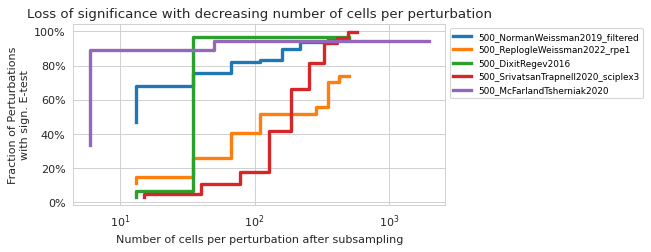

In [164]:
with sns.axes_style('whitegrid'):
    ax = pl.subplots(figsize=(6,3), dpi=80)[-1]
for i, file in enumerate(selected_files):
    dataset = file.name.replace('effect_of_ncells_', '').replace('_tables.csv', '')
    sdf = pd.read_csv(file, index_col=0)
    sdf = sdf[sdf.ncells>2].copy()  # not enough cells for e-test!
    ax = plot_KM(sdf, dataset, 'ncells', show=False, ax=ax)
ax.legend(fontsize=8, bbox_to_anchor=(1,1))
ax.set_title(f'Loss of significance with decreasing number of cells per perturbation')
ax.set_xlabel('Number of cells per perturbation after subsampling')
ax.set_xscale('log')
pl.savefig(figure_path / f'Fig5_ncells_500_joint_KMplot.pdf', bbox_inches='tight')
pl.show()

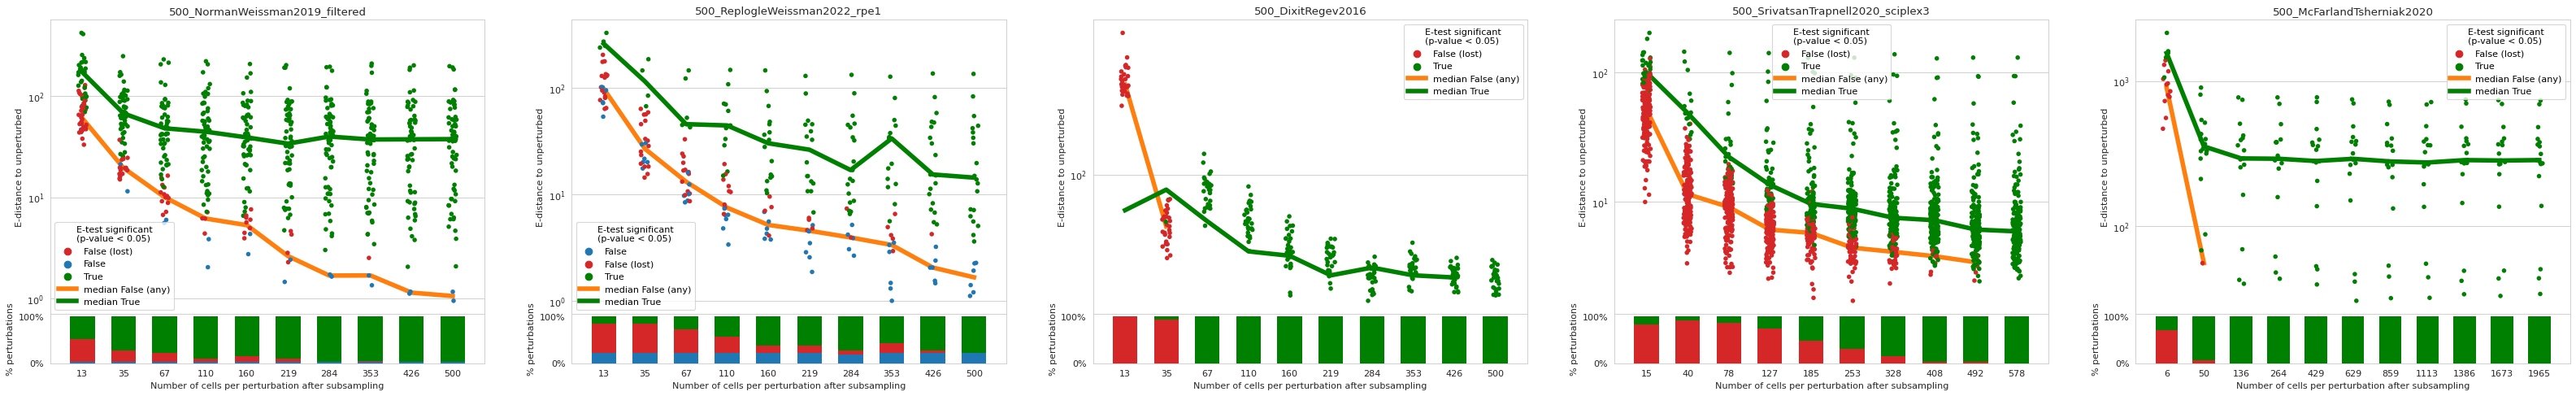

In [142]:
# Ncells
files = selected_files
N=len(files)
with sns.axes_style('whitegrid'):
    axss = pl.subplots(2, N, figsize=(10*N, 7), dpi=80, gridspec_kw={'height_ratios':[6, 1], 'hspace': 0}, sharex='col')[-1]
for file, axs in zip(files, axss.T):
    sdf = pd.read_csv(file, index_col=0)
    dataset = file.name.replace('effect_of_ncells_', '').replace('_tables.csv', '')
    plot_strip(sdf, dataset, 'ncells', ax=axs[0], save=False, show=False)
    plot_freqs(sdf, ax=axs[1], xkey='ncells')
pl.savefig(figure_path / f'Fig5_ncells_500_joint_all_strips.pdf', bbox_inches='tight')
pl.show()    

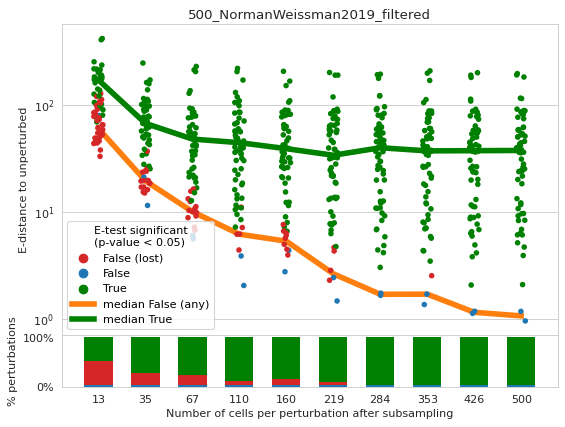

In [169]:
# Ncells Norman
file = Path('../snakemake/tables/500_effect_of_ncells_NormanWeissman2019_filtered_tables.csv')
with sns.axes_style('whitegrid'):
    axs = pl.subplots(2, 1, figsize=(8*1, 6), dpi=80, gridspec_kw={'height_ratios':[6, 1], 'hspace': 0}, sharex='col')[-1]
sdf = pd.read_csv(file, index_col=0)
dataset = file.name.replace('effect_of_ncells_', '').replace('_tables.csv', '')
plot_strip(sdf, dataset, 'ncells', ax=axs[0], save=False, show=False)
plot_freqs(sdf, ax=axs[1], xkey='ncells')
pl.savefig(figure_path / f'Fig5_ncells_500_joint_Norman_strips.pdf', bbox_inches='tight')
pl.show()    

# Ncells (N_min=50)

In [143]:
files = list(Path(f'../snakemake/tables/').glob('effect_of_ncells_*'))
# exclude files with few total perturbations or no significant ones to lose to begin with
selected_files = []
for file in files:
    sdf = pd.read_csv(file, index_col=0)
    if len(sdf.perturbation.unique())<10 or ('True' not in sdf.significant_adj_new.value_counts().index):
        continue
    else:
        selected_files.append(file)

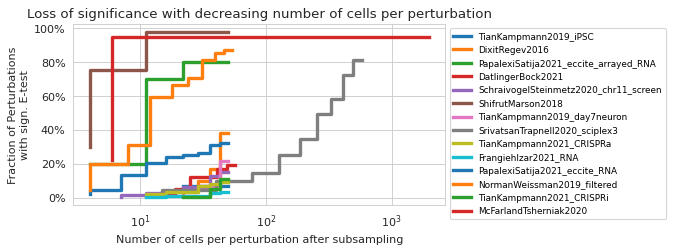

In [144]:
with sns.axes_style('whitegrid'):
    ax = pl.subplots(figsize=(6,3), dpi=80)[-1]
for i, file in enumerate(selected_files):
    dataset = file.name.replace('effect_of_ncells_', '').replace('_tables.csv', '')
    sdf = pd.read_csv(file, index_col=0)
    sdf = sdf[sdf.ncells>2].copy()  # not enough cells for e-test!
    ax = plot_KM(sdf, dataset, 'ncells', show=False, ax=ax)
ax.legend(fontsize=8, bbox_to_anchor=(1,1))
ax.set_title(f'Loss of significance with decreasing number of cells per perturbation')
ax.set_xlabel('Number of cells per perturbation after subsampling')
ax.set_xscale('log')
pl.savefig(figure_path / f'Fig5_ncells_50_joint_KMplot.pdf', bbox_inches='tight')
pl.show()

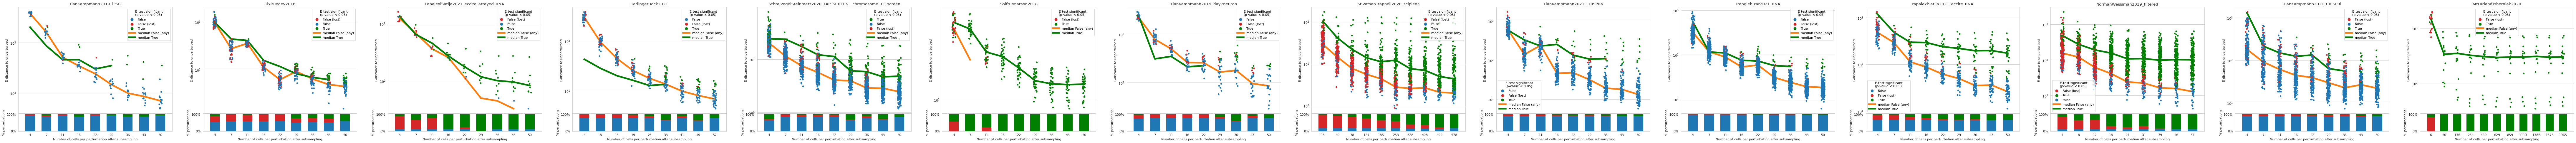

In [145]:
# Ncells
files = selected_files
N=len(files)
with sns.axes_style('whitegrid'):
    axss = pl.subplots(2, N, figsize=(10*N, 7), dpi=80, gridspec_kw={'height_ratios':[6, 1], 'hspace': 0}, sharex='col')[-1]
for file, axs in zip(files, axss.T):
    sdf = pd.read_csv(file, index_col=0)
    dataset = file.name.replace('effect_of_ncells_', '').replace('_tables.csv', '')
    plot_strip(sdf, dataset, 'ncells', ax=axs[0], save=False, show=False)
    plot_freqs(sdf, ax=axs[1], xkey='ncells')
pl.savefig(figure_path / f'Fig5_ncells_50_joint_all_strips.pdf', bbox_inches='tight')
pl.show()    

# Dependence on nPCs

In [187]:
files = list(Path(f'../snakemake/tables/').glob('effect_of_nPCs_*'))
# exclude files with few total perturbations or no significant ones to lose to begin with
selected_files = []
for file in files:
    sdf = pd.read_csv(file, index_col=0)
    if len(sdf.perturbation.unique())<30 or ('True' not in sdf.significant_adj_new.value_counts().index):
        continue
    else:
        selected_files.append(file)

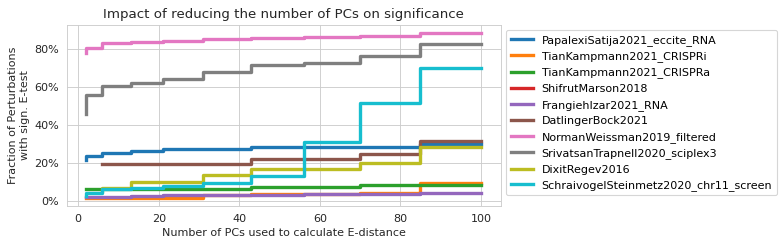

In [188]:
with sns.axes_style('whitegrid'):
    ax = pl.subplots(figsize=(7,3), dpi=80)[-1]
for file in selected_files:
    dataset = file.name.replace('effect_of_nPCs_', '').replace('_tables.csv', '')
    sdf = pd.read_csv(file, index_col=0)
    ax = plot_KM(sdf, dataset, 'n', show=False, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f'Impact of reducing the number of PCs on significance')
ax.set_xlabel('Number of PCs used to calculate E-distance')
# ax.set_xscale('log')
pl.savefig(figure_path / f'SuppFig5_nPCs_joint_KMplot.pdf', bbox_inches='tight')
pl.show()

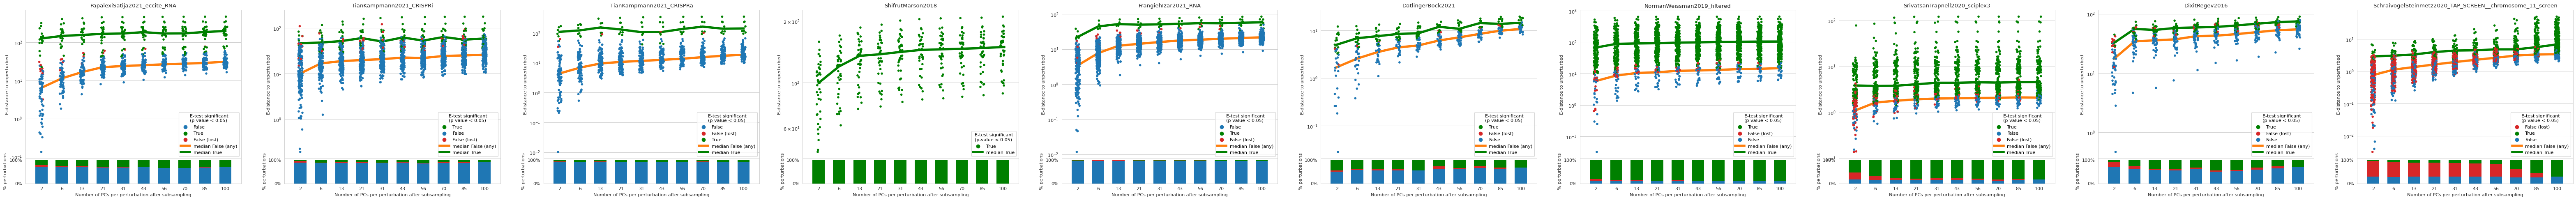

In [160]:
N=len(selected_files)
with sns.axes_style('whitegrid'):
    axss = pl.subplots(2, N, figsize=(10*N, 7), dpi=80, gridspec_kw={'height_ratios':[6, 1], 'hspace': 0}, sharex='col')[-1]
for file, axs in zip(selected_files, axss.T):
    sdf = pd.read_csv(file, index_col=0)
    dataset = file.name.replace('effect_of_nPCs_', '').replace('_tables.csv', '')
    plot_strip(sdf, dataset, 'nPCs', ax=axs[0], save=False, show=False)
    plot_freqs(sdf, ax=axs[1], xkey='nPCs')
pl.savefig(figure_path / f'SuppFig5_nPCs_joint_all_strips.pdf', bbox_inches='tight')
pl.show()

# Dependence on nHVGs

In [189]:
files = list(Path(f'../snakemake/tables/').glob('effect_of_nHVGs_*'))
# exclude files with few total perturbations or no significant ones to lose to begin with
selected_files = []
for file in files:
    sdf = pd.read_csv(file, index_col=0)
    if len(sdf.perturbation.unique())<30 or ('True' not in sdf.significant_adj_new.value_counts().index) or 'Marson' in file.name:
        continue
    else:
        selected_files.append(file)

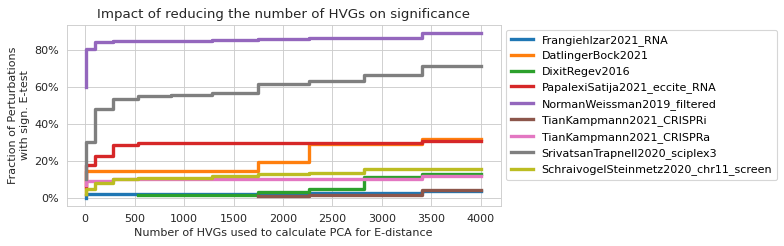

In [190]:
with sns.axes_style('whitegrid'):
    ax = pl.subplots(figsize=(7,3), dpi=80)[-1]
for file in selected_files:
    dataset = file.name.replace('effect_of_nHVGs_', '').replace('_tables.csv', '')
    sdf = pd.read_csv(file, index_col=0)
    ax = plot_KM(sdf, dataset, 'n', show=False, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f'Impact of reducing the number of HVGs on significance')
ax.set_xlabel('Number of HVGs used to calculate PCA for E-distance')
# ax.set_xscale('log')
pl.savefig(figure_path / f'SuppFig5_nHVGs_joint_KMplot.pdf', bbox_inches='tight')
pl.show()

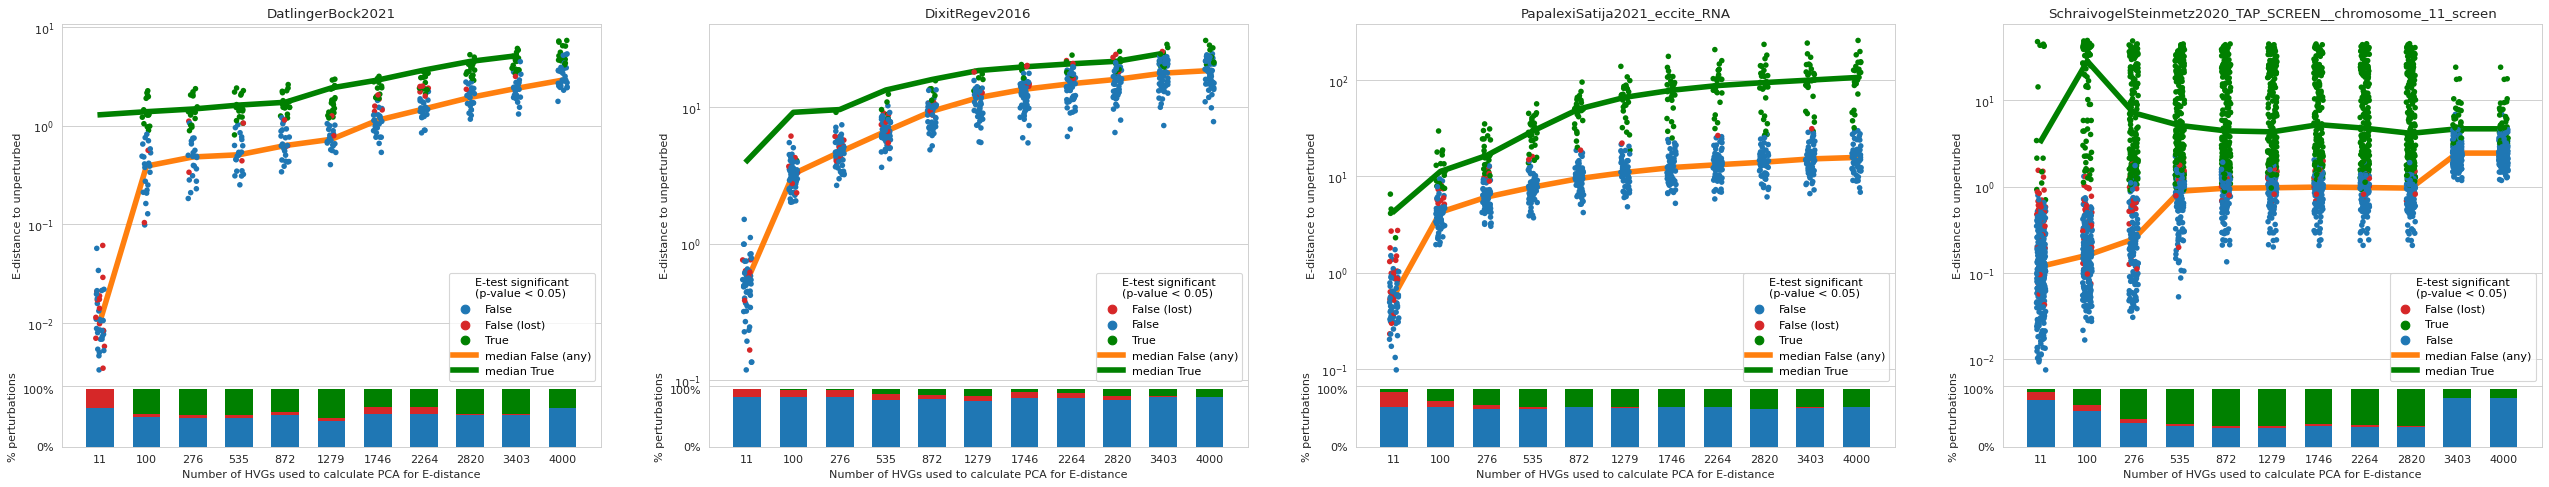

In [177]:
N=len(selected_files)
with sns.axes_style('whitegrid'):
    axss = pl.subplots(2, N, figsize=(10*N, 7), dpi=80, gridspec_kw={'height_ratios':[6, 1], 'hspace': 0}, sharex='col')[-1]
for file, axs in zip(selected_files, axss.T):
    sdf = pd.read_csv(file, index_col=0)
    dataset = file.name.replace('effect_of_nHVGs_', '').replace('_tables.csv', '')
    plot_strip(sdf, dataset, 'nPCs', ax=axs[0], save=False, show=False)
    plot_freqs(sdf, ax=axs[1], xkey='nPCs')
    axs[1].set_xlabel('Number of HVGs used to calculate PCA for E-distance')
pl.savefig(figure_path / f'SuppFig5_nHVGs_joint_all_strips.pdf', bbox_inches='tight')
pl.show()    

# Joint (ncells, ncounts) subsampling (deprecated, results not convincing, high effort)

In [20]:
# this will be a complicated tensor I guess
# %ncounts x %ncells x perturbation x significance/distance
# I will lose the tensor structure when moving from % to absolutes
# Then could catch number of insig perturbations and make it a scatter with ncells and ncounts the x and y coords, then color background

In [73]:
dataset = 'PapalexiSatija2021_eccite_RNA'
# dataset = 'NormanWeissman2019_filtered'
# dataset = 'SrivatsanTrapnell2020_sciplex3'

control = 'control'
groupby = 'perturbation'

In [74]:
sdf = pd.read_csv(f'../snakemake/tables/save_effect_of_both_{dataset}_tables.csv', index_col=0)

sdf['significant_adj_new'] = sdf['significant_adj']
for g in sdf.perturbation.unique():
    if sdf['significant_adj'][(sdf[groupby]==g) & (sdf['n']=='1.0_1.0')].iloc[0]==True:
        sdf['significant_adj_new'][(sdf[groupby]==g) & (sdf['significant_adj']==False)] = 'False (lost)'
    elif sdf['significant_adj'][(sdf[groupby]==g) & (sdf['n']=='1.0_1.0')].iloc[0]==False:
        sdf['significant_adj_new'][(sdf.perturbation==g) & (sdf['significant_adj']==True)] = 'True (gained)'
        
sdf[['n_cells', 'n_counts']] = np.array([x.split('_') for x in sdf.n], dtype='float')
sdf.head()

n perturbation      edist  pvalue  \
0  0.010178558119067316_0.010178558119067316       ATF2g1  42.070234     0.0   
1  0.010178558119067316_0.010178558119067316       ATF2g2  52.678040     0.0   
2  0.010178558119067316_0.010178558119067316       ATF2g3  55.735894     0.0   
3  0.010178558119067316_0.010178558119067316       ATF2g4  53.237979     0.0   
4  0.010178558119067316_0.010178558119067316       BRD4g1  47.112235     0.0   

   significant  pvalue_adj significant_adj      delta  sigma  ncounts  ncells  \
0         True         0.0            True  21.035117    0.0     73.0       1   
1         True         0.0            True  26.339020    0.0     36.0       1   
2         True         0.0            True  27.867947    0.0     34.0       1   
3         True         0.0            True  26.618989    0.0     42.0       1   
4         True         0.0            True  23.556118    0.0     40.0       1   

  significant_adj_new   n_cells  n_counts  
0                True  0.010179  0.010179  
1                True  0.010179  0.010179  
2                True  0.010179  0.010179  
3                True  0.010179  0.010179  
4                True  0.010179  0.010179

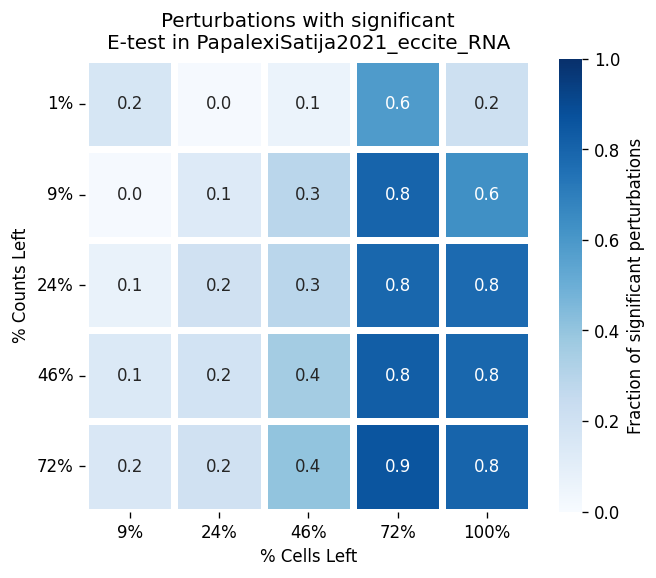

In [75]:
A = pd.DataFrame(0, index=sdf.n_counts.unique(), columns=sdf.n_cells.unique())
for nco in sdf.n_counts.unique():
    for nce in sdf.n_cells.unique():
        cts = sdf[(sdf.n_counts==nco) & (sdf.n_cells==nce)].significant_adj.value_counts()
        A.loc[nco, nce] = cts['True'] / np.sum(cts) if 'True' in cts.index else 0  # percent significant
A.index = [str(int(np.round(k,2)*100))+'%' for k in A.index]
A.columns = [str(int(np.round(k,2)*100))+'%' for k in A.columns]

fig, ax = pl.subplots(figsize=(6,5), dpi=120)
B = A.iloc[:-1,1:]  # papalexi
sns.heatmap(B, vmin=0, vmax=1, cmap='Blues', linewidths=4, annot=True, fmt='.1f',
            cbar_kws={'label': 'Fraction of significant perturbations'});
pl.title(f'Perturbations with significant\nE-test in {dataset}');
pl.ylabel('% Counts Left')
pl.xlabel('% Cells Left')
pl.yticks(rotation=0)
pl.show()

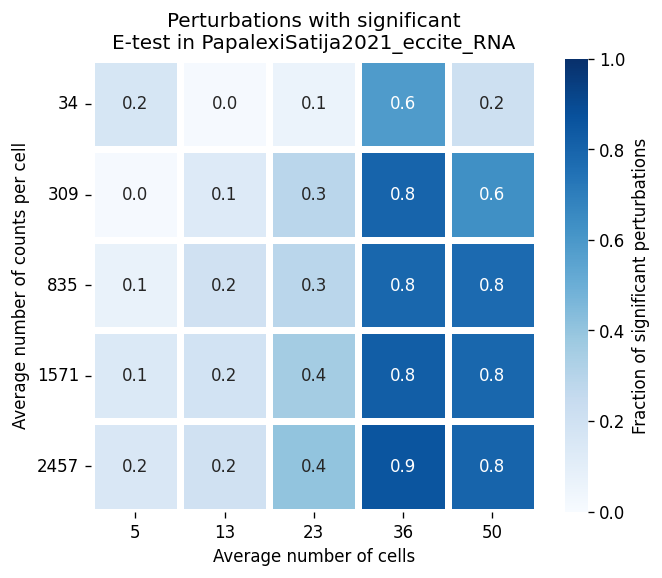

In [76]:
A = pd.DataFrame(0, index=sdf.n_counts.unique(), columns=sdf.n_cells.unique())
for nco in sdf.n_counts.unique():
    for nce in sdf.n_cells.unique():
        cts = sdf[(sdf.n_counts==nco) & (sdf.n_cells==nce)].significant_adj.value_counts()
        A.loc[nco, nce] = cts['True'] / np.sum(cts) if 'True' in cts.index else 0  # percent significant
# A.index = [str(int(np.round(k,2)*100))+'%' for k in A.index]
# A.columns = [str(int(np.round(k,2)*100))+'%' for k in A.columns]
A.index = sdf.groupby(['n_counts']).mean().ncounts.astype(int)
A.columns = sdf.groupby(['n_cells']).mean().ncells.astype(int)

fig, ax = pl.subplots(figsize=(6,5), dpi=120)
B = A.iloc[:-1,1:]  # papalexi
sns.heatmap(B, vmin=0, vmax=1, cmap='Blues', linewidths=4, annot=True, fmt='.1f',
            cbar_kws={'label': 'Fraction of significant perturbations'});
pl.title(f'Perturbations with significant\nE-test in {dataset}');
pl.ylabel('Average number of counts per cell')
pl.xlabel('Average number of cells')
pl.yticks(rotation=0)
pl.show()

In [56]:
sdf.groupby(['n_cells', 'n_counts']).mean().reset_index().pivot('n_cells', 'n_counts', 'edist')

n_counts  0.004266  0.038174   0.104837   0.201983   0.326304   0.473568  \
n_cells                                                                    
0.004266  0.881008  5.761057  15.555062  28.720914  40.014541  57.517290   
0.038174  0.079738  0.363467   1.213720   2.043115   3.312960   4.656468   
0.104837  0.038223  0.211547   0.692363   1.277916   2.104663   3.197538   
0.201983  0.050841  0.480159   0.913352   1.784160   3.180761   4.707417   
0.326304  0.130108  1.048000   2.337169   3.509903   5.500080   8.416220   
0.473568  0.096239  0.690277   1.613878   2.764028   4.473668   6.696484   
0.638758  0.106109  0.533988   1.233419   2.224544   3.434343   5.104725   
0.816250  0.236424  1.111695   2.073870   3.668196   6.150858   9.732821   
1.000000  0.196721  0.885409   1.864508   3.109166   5.278070   8.298979   

n_counts   0.638758   0.816250  1.000000  
n_cells                                   
0.004266  74.405966  93.665119  8.333141  
0.038174   5.942866   7.623166  8.333141  
0.104837   4.553312   6.329181  8.333141  
0.201983   6.776111   9.371071  8.333141  
0.326304  12.233537  17.051004  8.333141  
0.473568   9.614877  13.417280  8.333141  
0.638758   7.352593  10.069357  8.333141  
0.816250  14.389007  19.885761  8.333141  
1.000000  12.185359  16.752506  8.333141

In [57]:
sdf.groupby(['n_cells', 'n_counts']).mean().reset_index().pivot('n_cells', 'n_counts', 'significant')

n_counts  0.004266  0.038174  0.104837  0.201983  0.326304  0.473568  \
n_cells                                                                
0.004266  0.687831  0.216931  0.269841  0.677249  0.264550  0.291005   
0.038174  0.010582  0.031746  0.158730  0.153439  0.169312  0.142857   
0.104837  0.037037  0.201058  0.544974  0.582011  0.592593  0.603175   
0.201983  0.375661  0.624339  0.693122  0.714286  0.740741  0.708995   
0.326304  0.777778  0.894180  0.910053  0.941799  0.941799  0.947090   
0.473568  0.597884  0.708995  0.788360  0.798942  0.804233  0.788360   
0.638758  0.460317  0.910053  0.830688  0.846561  0.857143  0.830688   
0.816250  0.899471  0.978836  0.984127  0.984127  0.989418  0.984127   
1.000000  0.788360  0.915344  0.941799  0.931217  0.936508  0.931217   

n_counts  0.638758  0.816250  1.000000  
n_cells                                 
0.004266  0.238095  0.227513  0.931217  
0.038174  0.095238  0.105820  0.931217  
0.104837  0.592593  0.597884  0.931217  
0.201983  0.714286  0.719577  0.931217  
0.326304  0.952381  0.952381  0.931217  
0.473568  0.788360  0.788360  0.931217  
0.638758  0.809524  0.798942  0.931217  
0.816250  0.984127  0.984127  0.931217  
1.000000  0.931217  0.925926  0.931217

# Complete multipanel (outdated)

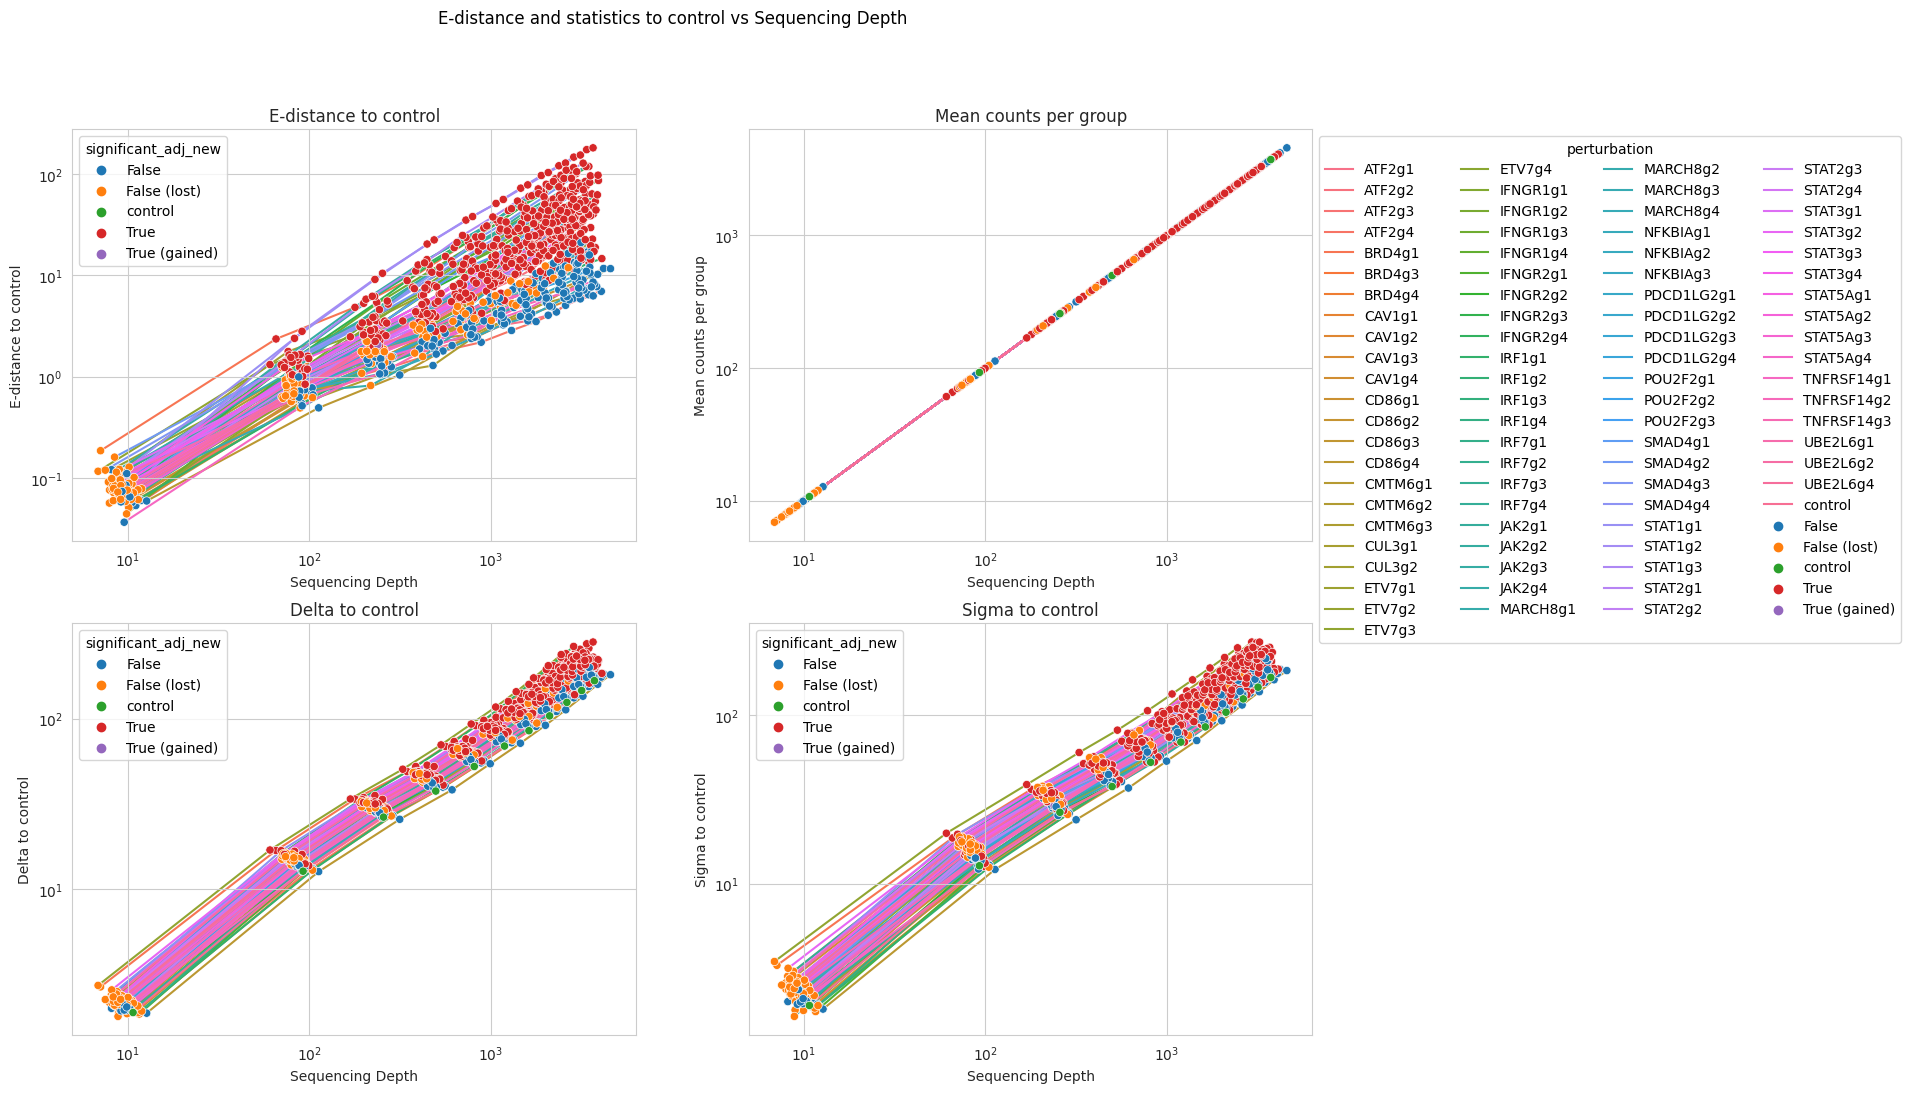

In [216]:
x = 'ncounts'
xlabel = 'Sequencing Depth'

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 2, figsize=(8*2,6*2), dpi=100)
lineplot_kwargs = dict(hue=groupby, color='grey', x=x, zorder=-1)
scatterplot_kwargs = dict(hue='significant_adj_new', marker="o", x=x)

for y, ax, title in zip(['edist', 'ncounts', 'delta', 'sigma'],
                        np.ravel(axs),
                        [f'E-distance to {control}', 'Mean counts per group', f'Delta to {control}', f'Sigma to {control}']
                       ):
    plot=sns.lineplot(data=sdf, ax=ax, y=y, legend=ax==axs[0,-1], **lineplot_kwargs)
    sns.scatterplot(data=sdf, ax=ax, y=y, **scatterplot_kwargs)
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(xlabel)
    
    # merge tight legend
    if y=='ncounts':
        h,l = plot.axes.get_legend_handles_labels()
        plot.axes.legend_.remove()
        ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

pl.suptitle(f'E-distance and statistics to {control} vs {xlabel}')
pl.savefig(f'../{dataset}_ncounts_complete_loglog.pdf', bbox_inches='tight')
pl.show()

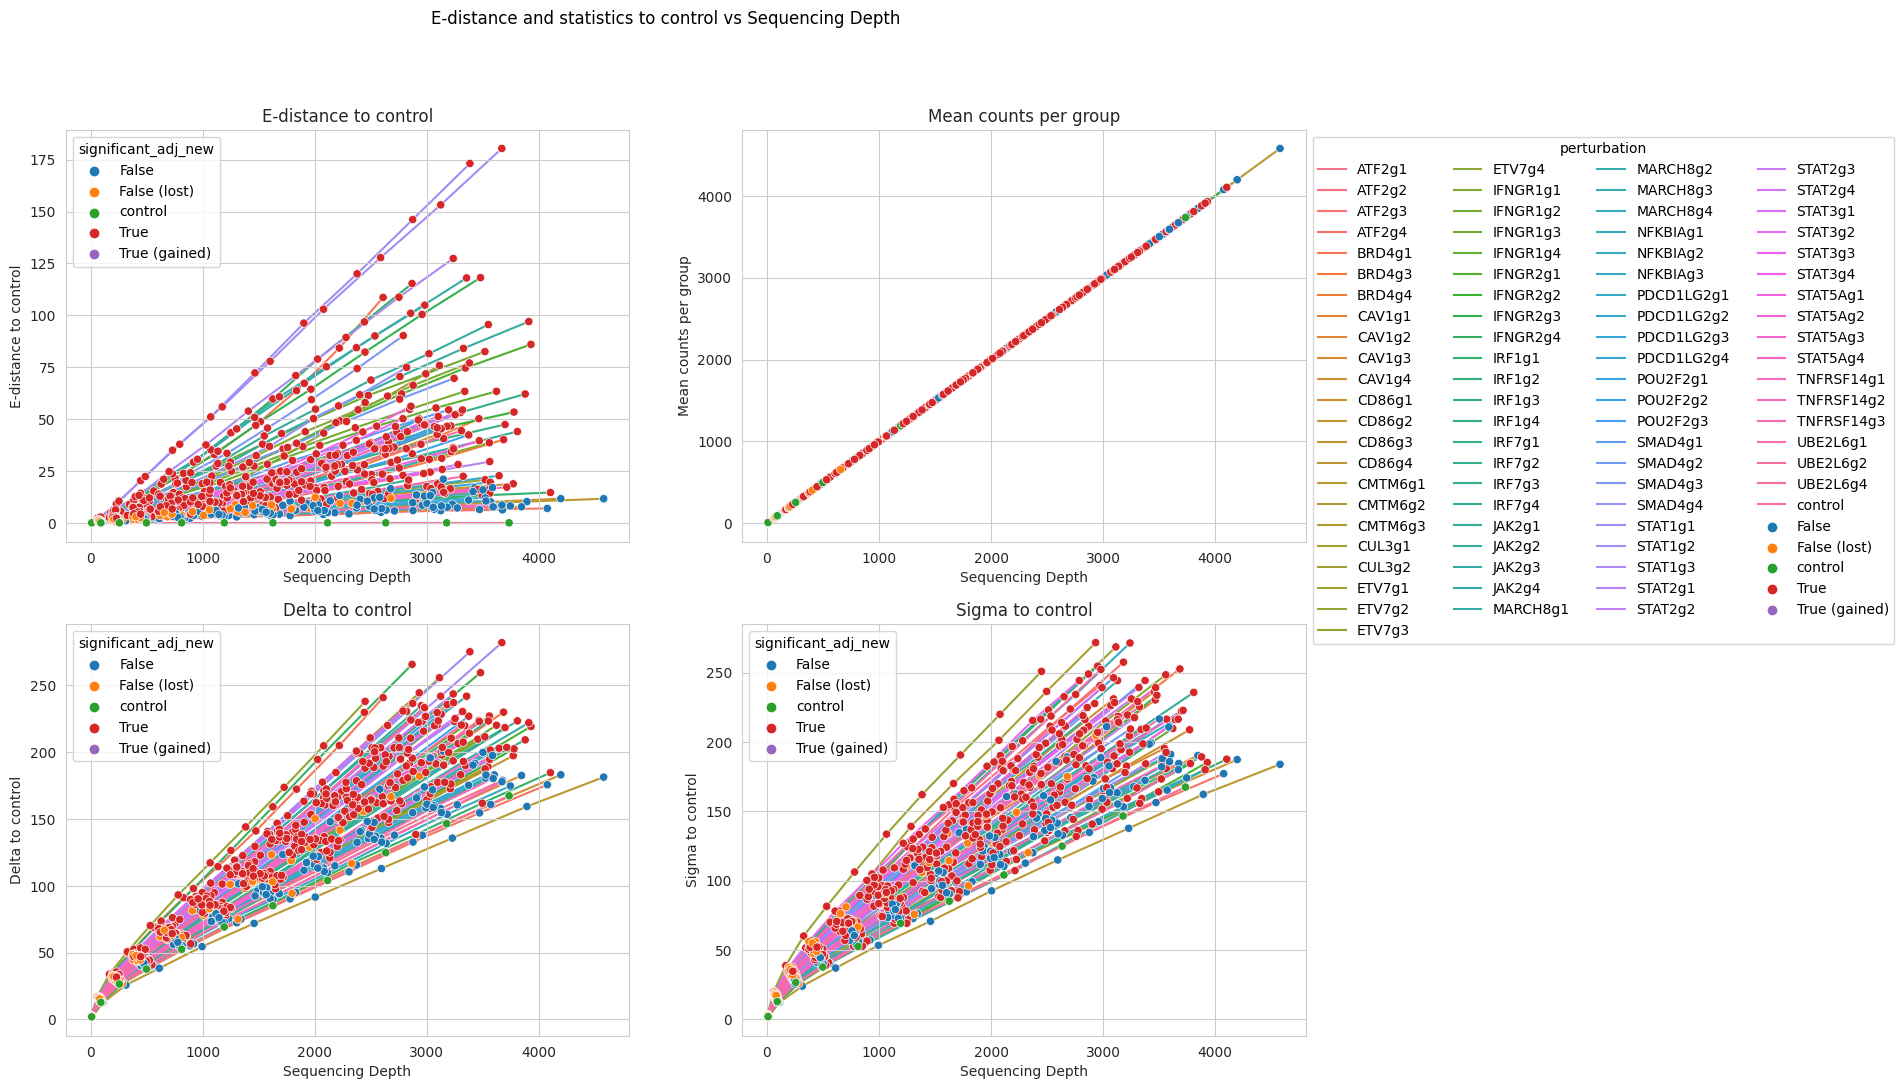

In [217]:
x = 'ncounts'
xlabel = 'Sequencing Depth'

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 2, figsize=(8*2,6*2), dpi=100)
lineplot_kwargs = dict(hue=groupby, color='grey', x=x, zorder=-1)
scatterplot_kwargs = dict(hue='significant_adj_new', marker="o", x=x)

for y, ax, title in zip(['edist', 'ncounts', 'delta', 'sigma'],
                        np.ravel(axs),
                        [f'E-distance to {control}', 'Mean counts per group', f'Delta to {control}', f'Sigma to {control}']
                       ):
    plot=sns.lineplot(data=sdf, ax=ax, y=y, legend=ax==axs[0,-1], **lineplot_kwargs)
    sns.scatterplot(data=sdf, ax=ax, y=y, **scatterplot_kwargs)
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    
    # merge tight legend
    if y=='ncounts':
        h,l = plot.axes.get_legend_handles_labels()
        plot.axes.legend_.remove()
        ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

pl.suptitle(f'E-distance and statistics to {control} vs {xlabel}')
pl.savefig(f'../{dataset}_ncounts_complete.pdf', bbox_inches='tight')
pl.show()